### Live Bubble Detection
This Notebook takes live data from the camera and feeds it to the bubble detection code.
The Notebook format is useful here since you need to edit a few variables by hand for the detection to work correctly.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from object_tracker import *
from CamController import CamController
import time

CamController establishes a connection to the camera.
You might want to use "MBDirector2 KIT" to set up the camera correctly before establishing a connection, since they are mutually exclusive. 

In [2]:
cam_con = CamController()

Tweak the "ignore" variables and rerun this cell until the region of interest is blue and everything else orange.

you should lean towards region of interest being slightly smaller since shadows at the edge of the roi could be interpreted as bubbles by the detector which would contaminate your data.

Note that the output of cam_con will alsways be square, so if the aspect ratio of the camera has been changed, there will be junk data at the end of the shorter aspect ration dimension. Make sure this junk data is outside the ROI.

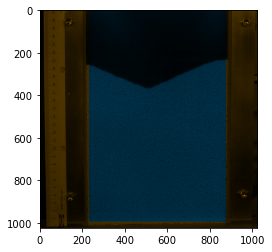

In [3]:
test_frame = cam_con.get_frame()
### CAMERA CALIBRATION ###

def apply_roi(frame, roi):
    return frame[roi[1]:roi[3], roi[0]:roi[2]]

def zero_non_roi(frame, roi):
    frame = np.copy(frame)
    frame[0:roi[1]] = 0
    frame[roi[3]:-1] = 0
    frame[:,0:roi[0]] = 0
    frame[:, roi[2]:-1] = 0
    return frame

# calibrate video to only include particles (region of interest)
width, height = test_frame.shape
# adjust these:
ignore_left = 230
ignore_right = 150
ignore_top = 0
ignore_bottom = 30
roi = (ignore_left, ignore_top, width-ignore_right, height - ignore_bottom)

# constuct calibration image to visually confirm
roi_frame = zero_non_roi(test_frame, roi)
no_roi_frame = test_frame - roi_frame
rgb_frame = np.zeros((width, height, 3))
rgb_frame[:,:,2] = roi_frame
rgb_frame[:,:,0] = no_roi_frame
rgb_frame[:,:,1] = test_frame / 1.5

# blue should be area of interest
plt.imshow(rgb_frame / 256)

Next you need to adjust the "threshhold_value", until the bubbles show up clearly as white spots. (have at least one Flow unit running during this, using the "Flow_Control" Notebook)

The Ideal value for this changes based on time of day so run this cell regularly if you're working long hours

You should also see some smaller white spots in the fluid bed, don't worry about these, since they will be removed during the detection process and are a sign that you aren't removing too much detail.

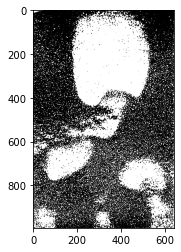

In [6]:
test_frame = cam_con.get_frame()
test_frame = test_frame[roi[1]:roi[3], roi[0]:roi[2]]

# adjust this:
threshhold_value = 55

ret, thresh = cv2.threshold(test_frame, threshhold_value, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap="Greys")

In [8]:
# This cell is setup code for the detector, leave as is

results_df = pd.DataFrame(columns=['video_name', 
                                   'frame_number', 
                                   'time [sec]', 
                                   'num_contours_per_frame', 
                                   'ID', 
                                   'cx_pos [px]', 
                                   'cy_pos [px]', 
                                   'cx_pos [m]',
                                   'cy_pos [m]', 
                                   'size [px^2]', 
                                   'size [m^2]', 
                                   'perimeter [px]',
                                   'perimeter [m]',
                                   'approx_diameter [px]',
                                   'approx_diameter [m]',
                                   'x_velocity [m/s]',
                                   'y_velocity [m/s]'])

file_name = "test_images.avi"

# Constants
#VIDEO_PATH = r'D:\V30_20240418_125938_20240418_130046.avi'
#OUTPUT_VIDEO_NAME = 'umf_1_0.avi'
WIN_SIZE = (15, 5)

# Create tracker object
tracker = EuclideanDistTracker(width)

# Define the codec and create VideoWriter object so that we have the 
# resulting video saved
OUTPUT_VIDEO_NAME = "test.mp4"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(OUTPUT_VIDEO_NAME, fourcc, 50, (width, height - ignore_bottom))

# Scale bar length in pixels (adjust as needed)
scale_bar_length = 42.6

# Lists to store data for the diagram
average_sizes_contours = []
total_sizes_contours = []
num_contours_per_frame = []
ids_and_sizes = {}
first_detected_frame = {}

# Read the first frame from the video
# ret, _ = cap.read()
# why?

# Counter for frame number
frame_number = 0  


The cell below is the main loop of the detector, I've changed it so it takes live frames from the camera as fast as it can process them. It will open live videos while proccessing, that you can use to make sure everything is being tracked correctly.

I you want to aply controls or run other code during the live analysis you should do it in this loop.

The 600 iterations are just so the loop would eventually stop during testing, you should change the loop condition to whatever suits your needs

In [9]:
start_time = None
for i in range(600):
    frame = cam_con.get_frame()
    if start_time is None:
        start_time = time.time()
        cur_time = 0.0
    else:
        cur_time = time.time()-start_time

        
        
    # Below code is doint the bubble detection and tracking, leave as is unless you know what you're doint
    
    # 100 cm is 1920 px
    # 10 cm is 192 px
    # 1 cm is 19.2 px

    # Add a scale bar at the top-right corner
    scale_bar_start = (20, 430-192)
    scale_bar_end = (20, 430)

    #scale_bar_start = (width - 10 - scale_bar_length, 10)
    #scale_bar_end = (width - 10, 10)
    sc_start = (30, 430-384)
    sc_end = (30, 430)

    cv2.line(frame, scale_bar_start, scale_bar_end, (0, 0, 255), 2)
    cv2.line(frame, sc_start, sc_end, (0, 0, 255), 2)

    #cv2.imshow('testing', frame)
    # Apply ROI
    frame = frame[roi[1]:roi[3], roi[0]:roi[2]]

    # Greyscaling of the image
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # image is already gray
    gray = frame

    # Normal Thresholding
    # ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    ret, thresh = cv2.threshold(gray, 63, 255, cv2.THRESH_BINARY)

    # Create a circular kernels
    radius_dil = 2
    radius_ero = 6

    kernel_dil = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius_dil+1, 2*radius_dil+1))
    kernel_ero = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius_ero+1, 2*radius_ero+1))

    # Ero and dil with circular kernel
    morphed_thresh_dil = cv2.dilate(thresh, kernel_dil, iterations = 1)
    morphed_thresh_ero = cv2.erode(morphed_thresh_dil, kernel_ero, iterations = 1)

    # Find contours in the inverse of the morphed thresholded image
    contours, _ = cv2.findContours(~morphed_thresh_ero, 
                                cv2.RETR_EXTERNAL, 
                                cv2.CHAIN_APPROX_SIMPLE)

    detections = []
    # Sort contours by area or intensity
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    num_contours_to_draw = min(10, len(contours))
    total_size_contour = 0
    #curves_for_frame = []
    contours_for_counting = []
    size_list = []
    perimeter_list = []
    #for i in range(min(num_contours_to_draw, len(contours))):
    for i in range(0, num_contours_to_draw):
        contour = contours[i]

        if (len(contour) >= 5 and cv2.contourArea(contour) > 500  
            and cv2.contourArea(contour) < 150000):

                #-------------------------------------------------------------
                # determine smoothness of contours
                epsilon = 0.0005 * cv2.arcLength(contour, True)
                smooth_contour = cv2.approxPolyDP(contour, epsilon, True)

                # Calculate centroids of Contours
                M = cv2.moments(contour)

                # Calculate centroid using moments
                if M["m00"] != 0:
                    centroid_x = int(M["m10"] / M["m00"])
                    centroid_y = int(M["m01"] / M["m00"])
                else:
                    centroid_x, centroid_y = 0, 0

                cv2.drawContours(frame, [smooth_contour], -1, (255, 0, 0), 2)

                center_contour = (int(centroid_x), int(centroid_y))

                detections.append(center_contour)

                cv2.circle(frame, (centroid_x, centroid_y), 5, (255, 0, 0), -1)

                contours_for_counting.append(contour)

                # Display the size of the contour as text
                size_text = f"Size Contour: {int(cv2.contourArea(contour))} px^2"
                cv2.putText(frame, size_text, 
                            (int(centroid_x), int(centroid_y)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                            (255, 255, 255), 2)

                # Calculate total size for averaging
                size_list.append(round(cv2.contourArea(contour), 4))
                perimeter_list.append(round(cv2.arcLength(contour, True), 4))
                total_size_contour += cv2.contourArea(contour)

    # 2. Object Tracking
    objects_ids = tracker.update(detections, frame_number)
    dict_cx = {}
    dict_cy = {}
    dict_center_of_mass = {}

    for object_id in objects_ids:
        cx, cy, id = object_id
        dict_cx[id] = cx
        dict_cy[id] = cy
        dict_center_of_mass[id] = (cx, cy)
        cv2.putText(frame, "ID: " + str(id), (cx, cy+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)


    # Calculate average size
    if len(contour) > 0:

        average_size_contour = total_size_contour / len(contour)
        average_sizes_contours.append(average_size_contour)
        total_sizes_contours.append(total_size_contour)
        num_contours_per_frame.append(len(contours_for_counting))

        for object_id, size in zip(objects_ids, average_sizes_contours):
            _, _, id = object_id
            if id not in ids_and_sizes:
                ids_and_sizes[id] = size
                first_detected_frame[id] = frame_number

        # Display live numbers on the frame
        cv2.putText(frame, f"Average Size Contours/Frame: {average_size_contour:.2f} px^2", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.8, (255, 255, 255), 2)
        cv2.putText(frame, f"Number of Contours: {len(contours_for_counting)}",
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.8, (255, 255, 255), 2)

    # Save Processed Frame to Output Video
    #output_video.write(frame)

    # Visualization
    cv2.imshow('dil+ero', ~morphed_thresh_ero)
    cv2.imshow('dil', ~morphed_thresh_dil)
    cv2.imshow('Processed Frame', frame)

    key = cv2.waitKey(30)
    if key == 27:
        break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    #print("---------------")

    #print(frame_number)
    #print(dict_center_of_mass)
    #print(perimeter_list)
    #print(size_list)

    #print(dict_center_of_mass)

    list_counter = 0
    for id in dict_center_of_mass:

        # X and Y coordinates of center of bubble
        cx = dict_center_of_mass[id][0]
        cy = dict_center_of_mass[id][1]

        # diameter if bubble were a circle
        approx_diameter = 2*math.sqrt(((size_list[list_counter])/math.pi))

        # find ID in previous frame
        # look through the last 20 rows of the dataframe to find
        # the cx and cy position of the current bubble
        search_radius = 20
        x_velocity_meter_per_sec = 0
        y_velocity_meter_per_sec = 0
        # only works starting with the second frame
        if frame_number > 0:
            prev_frame = frame_number - 1
            # go through last 20 or through the whole df if it 
            # has less than 20 entries
            for x in range(0, min(search_radius, len(results_df))):
                # if the ID we are looking for is found in one 
                # of the previous rows and also if the frame 
                # number in that row is from the previous frame
                if id == results_df.iloc[-x]['ID'] and frame_number == (results_df.iloc[-x]['frame_number']+1):
                    # velocities are calculated in px first 
                    #(just current minus previous center 
                    #positions) and the redone in meter (/1920)
                    x_velocity_px_per_frame = (cx - results_df.iloc[-x]['cx_pos [px]'])
                    y_velocity_px_per_frame = (cy - results_df.iloc[-x]['cx_pos [px]'])
                    x_velocity_meter_per_frame = x_velocity_px_per_frame/1920
                    y_velocity_meter_per_frame = y_velocity_px_per_frame/1920
                    x_velocity_meter_per_sec = x_velocity_meter_per_frame*50
                    y_velocity_meter_per_sec = y_velocity_meter_per_frame*50

                    #print(str(id) + " had prev x pos: " + str(results_df.iloc[-x]['cx_pos']))
                    #print(str(id) + " had prev y pos: " + str(results_df.iloc[-x]['cy_pos']))
                    #print(str(id) + " now has x pos: " + str(cx))
                    #print(str(id) + " now has y pos: " + str(cy))
                    #print(x_velocity)
                    #print(y_velocity)

        # No velocity fro first frame can be calculated
        else: 
            x_velocity_meter_per_sec, y_velocity_meter_per_sec = 0, 0
            x_velocity_px_per_frame, y_velocity_px_per_frame = 0, 0

        # all the Information trackable so far
        #print("-----------")


        #print(size_list[list_counter]/(1920**2))
        #print((size_list[list_counter]*625/2304)*10**(-6))
       # print("frame_number: " + str(frame_number) + 
       #       ", time [sec]: " + str(cur_time) + 
       #       ", video_name: " + str(file_name) + 
       #       ', total_num_contours: ' + str(num_contours_per_frame[-1]) + 
       #       ", ID: " + str(id) + 
       #       ", CX: " + str(cx) + 
       #       ", CY: " + str(cy) + 
       #       ", size [px^2]: " + str(size_list[list_counter]) +
       #       ", size [m^2]: " + str(round(size_list[list_counter]/(1920**2), 8)) + 
       #       ", perimeter [px] : " + str(perimeter_list[list_counter]) + 
       #       ", perimeter [m]: " + str(round(perimeter_list[list_counter]/1920, 4)) +
       #       ", approx. diameter: " + str(round(approx_diameter, 4)))

        new_row = {'video_name': file_name,
                   'frame_number': frame_number, 
                   'time [sec]': cur_time, 
                   'num_contours_per_frame': num_contours_per_frame[-1],
                   'ID': id,
                   'cx_pos [px]': cx, 
                   'cy_pos [px]': cy,
                   'cx_pos [m]': round(cx/1920, 4), 
                   'cy_pos [m]': round(cy/1920, 4), 
                   'size [px^2]': size_list[list_counter],
                   'size [m^2]': round(size_list[list_counter]/(1920**2), 8),
                   'perimeter [px]': perimeter_list[list_counter],
                   'perimeter [m]': round(perimeter_list[list_counter]/1920, 4),
                   'approx_diameter [px]': round(approx_diameter, 4),
                   'approx_diameter [m]': round(approx_diameter/1920, 4),
                   'x_velocity [m/s]': round(x_velocity_meter_per_sec, 4),
                   'y_velocity [m/s]': round(y_velocity_meter_per_sec, 4)}
        results_df = results_df.append(new_row, ignore_index=True)

        list_counter += 1
    frame_number += 1
    #end of bubble detection
    

after the analysis is finished don't forget to close the cam connection and save the results Dataframe

In [10]:
cam_con.close()

In [11]:
results_df

,video_name,frame_number,time [sec],num_contours_per_frame,ID,cx_pos [px],cy_pos [px],cx_pos [m],cy_pos [m],size [px^2],size [m^2],perimeter [px],perimeter [m],approx_diameter [px],approx_diameter [m],x_velocity [m/s],y_velocity [m/s]
0,test_images.avi,0,0.000000,9,0,488,830,0.2542,0.4323,65678.0,0.017816,3704.5263,1.9294,289.1778,0.1506,0,0
1,test_images.avi,0,0.000000,9,1,66,929,0.0344,0.4839,15839.5,0.004297,1049.0752,0.5464,142.0122,0.0740,0,0
2,test_images.avi,0,0.000000,9,2,18,803,0.0094,0.4182,1307.5,0.000355,268.8356,0.1400,40.8015,0.0213,0,0
3,test_images.avi,0,0.000000,9,3,89,804,0.0464,0.4188,1295.5,0.000351,303.2620,0.1579,40.6138,0.0212,0,0
4,test_images.avi,0,0.000000,9,4,340,621,0.1771,0.3234,1044.0,0.000283,222.1076,0.1157,36.4590,0.0190,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029,test_images.avi,599,57.377282,10,1301,117,720,0.0609,0.3750,132993.5,0.036077,4535.6117,2.3623,411.5004,0.2143,0,0
3030,test_images.avi,599,57.377282,10,1302,461,854,0.2401,0.4448,81710.0,0.022165,3596.1588,1.8730,322.5467,0.1680,0,0
3031,test_images.avi,599,57.377282,10,1303,323,974,0.1682,0.5073,54090.0,0.014673,2456.7333,1.2795,262.4300,0.1367,0,0
3032,test_images.avi,599,57.377282,10,1289,222,752,0.1156,0.3917,8315.0,0.002256,592.8671,0.3088,102.8931,0.0536,0,0


In [12]:
# save to csv
results_df.to_csv(str(file_name) + "_results_df.csv")